In [1]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate,Dropout
from tensorflow.keras import Model

In [2]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.8 MB/s eta 0:00:00


In [3]:
from keras_tuner import HyperModel
import keras_tuner

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# open pickle file
with open('/content/drive/MyDrive/figs_class.pickle', 'rb') as handle:
  x_train, y_train, x_test, y_test = pickle.load(handle)

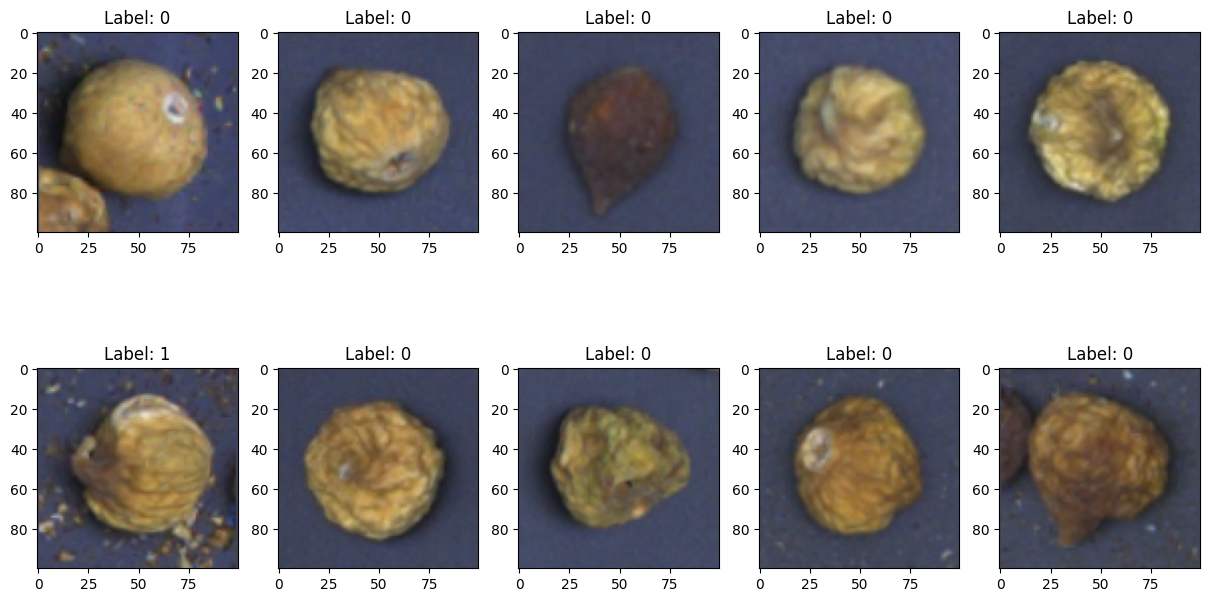

In [6]:
num_images = 10

random_indices=random.sample(range(len(x_train)),num_images)

images=[x_train[i] for i in random_indices]
labels = [y_train[i] for i in random_indices]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes = axes.flatten()
for i in range(num_images):
    axes[i].imshow(images[i][:,:,::-1])
    axes[i].set_title(f'Label: {labels[i]}')
plt.show()

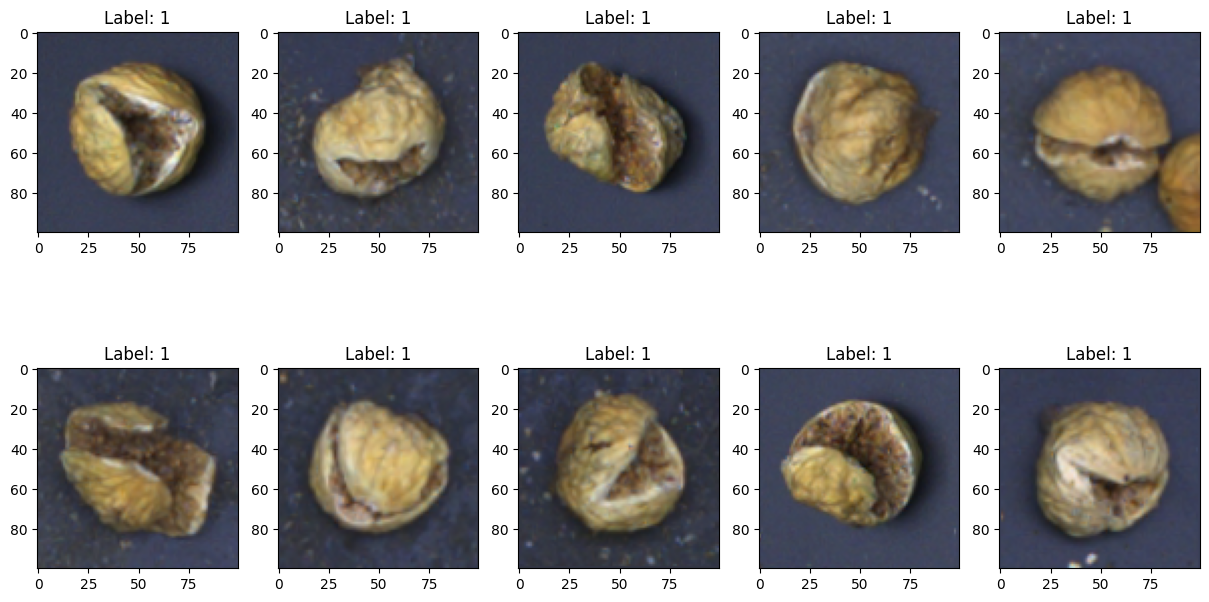

In [7]:
num_images = 10

images = []
labels = []
for i in range(len(y_train)):
    if y_train[i] == 1:
        images.append(x_train[i])
        labels.append(y_train[i])
        if len(images) == num_images:
            break

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes = axes.flatten()
for i in range(num_images):
    axes[i].imshow(images[i][:,:,::-1])
    axes[i].set_title(f'Label: {labels[i]}')
plt.show()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Define the image data generator with augmentation techniques
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

In [7]:
# Generate augmented data
augmented_train_data = train_datagen.flow(x_train, y_train)

In [8]:
# Concatenate the augmented data with the original data
x_train_augmented = x_train.copy()
y_train_augmented = y_train.copy()

for data in range(len(augmented_train_data)):
    x_train_augmented = np.concatenate((x_train_augmented, augmented_train_data[data][0]), axis=0)
    y_train_augmented = np.concatenate((y_train_augmented, augmented_train_data[data][1]), axis=0)

In [11]:
print(x_train_augmented.shape,y_train_augmented.shape)

(5786, 100, 100, 3) (5786,)


In [12]:
print(len(y_train_augmented[y_train_augmented>0])/len(y_train_augmented))

0.3446249567922572


In [9]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# count number each class
class_counts = Counter(y_train_augmented)

minority_class = min(class_counts, key=class_counts.get)
print(minority_class)

# تغییر شکل دادن داده‌های آموزشی
x_train_reshaped = np.reshape(x_train_augmented, (x_train_augmented.shape[0], -1))

print(x_train_augmented.shape,x_train_reshaped.shape)
n,img_width, img_height, img_channels=x_train_augmented.shape

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, y_train_augmented)
x_train_resampled = x_train_resampled.reshape(-1, img_width, img_height, img_channels)

print(x_train_resampled.shape,y_train_resampled.shape)

1
(5786, 100, 100, 3) (5786, 30000)
(7584, 100, 100, 3) (7584,)


In [10]:
print(len(y_train_resampled[y_train_resampled>0])/len(y_train_resampled))

0.5


In [11]:
from keras.callbacks import EarlyStopping
# Define the EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [12]:
from keras.callbacks import ModelCheckpoint
# Define the ModelCheckpoint callback.
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True, mode='max',
                             verbose=1)

In [13]:

x = x_train_resampled
y = y_train_resampled


n_samples = x.shape[0]


perm = np.random.permutation(n_samples)


x_train_resampled = x[perm]
y_train_resampled = y[perm]

In [18]:
print(y_train_resampled.shape)

print(y_train_resampled[:100])

(7584,)
[0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0
 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1]


In [14]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation data
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train_resampled, y_train_resampled, test_size=0.2)

In [15]:
from keras.utils import to_categorical
y_train_aug= to_categorical(y_train_aug)
y_test = to_categorical(y_test)
y_val= to_categorical(y_val)

In [16]:
x_train_aug=x_train_aug.astype('float32')/255.0
x_val=x_val.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

<h3>DenseNet</h3>

In [17]:
import tensorflow
import keras
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate


def bn_rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    return x


def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor


def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

def build_model(hp):
  dense_units = hp.Int('dense_units', min_value=256, max_value=2048, step=256)
  k = hp.Choice('k', values=[16, 32, 64])
  theta = hp.Float('theta', min_value=0.1, max_value=1.0, step=0.1)
  use_dropout = hp.Boolean('use_dropout')

  repetitions = 6, 12, 24, 16

  input = Input(shape=(100, 100, 3))

  x = Conv2D(2*k, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  for reps in repetitions:
      d = dense_block(x, k, reps)
      x = transition_layer(d, theta)

  x = GlobalAvgPool2D()(d)
  if use_dropout:
    x = Dropout(0.2)(x)
  x = Dense(dense_units, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)
  hp_learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])

  from tensorflow.keras import Model
  model = Model(input, output)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
   )
  return model

In [23]:
build_model(keras_tuner.HyperParameters())

In [24]:
hp = keras_tuner.HyperParameters()
print(hp.Int("units", min_value=32, max_value=512, step=32))

32


In [25]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/drive/MyDrive",
    project_name="helloworld",
)

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 2048, 'step': 256, 'sampling': 'linear'}
k (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
theta (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 1.0, 'step': 0.1, 'sampling': 'linear'}
use_dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [27]:
tuner.search(x_train_aug,
    y_train_aug,
    epochs=10,
    validation_data=(x_val, y_val),callbacks=[early_stop])

Trial 10 Complete [00h 06m 24s]
val_accuracy: 0.9014502167701721

Best val_accuracy So Far: 0.9215556979179382
Total elapsed time: 01h 34m 22s


In [29]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
best_model.build(input_shape=(100, 100, 3))
best_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 32)   4736        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 25, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 32)  128         ['max_pooling2d[0][0]']      

 re_lu_2 (ReLU)                 (None, 25, 25, 48)   0           ['batch_normalization_2[0][0]']  


 conv2d_3 (Conv2D)              (None, 25, 25, 64)   3136        ['re_lu_2[0][0]']                


 batch_normalization_3 (BatchNo  (None, 25, 25, 64)  256         ['conv2d_3[0][0]']               


 rmalization)                                                                                     
                                                                                                  
 re_lu_3 (ReLU)                 (None, 25, 25, 64)   0           ['batch_normalization_3[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 25, 25, 16)   9232        ['re_lu_3[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 25, 25, 64)   0           ['concatenate[0][0]',            
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 25, 25, 64)  256         ['concatenate_1[0][0]']          
 rmalizati

 concatenate_2 (Concatenate)    (None, 25, 25, 80)   0           ['concatenate_1[0][0]',          


                                                                  'conv2d_6[0][0]']               


 batch_normalization_6 (BatchNo  (None, 25, 25, 80)  320         ['concatenate_2[0][0]']          


 rmalization)                                                                                     


                                                                                                  
 re_lu_6 (ReLU)                 (None, 25, 25, 80)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_7 (Conv2D)              (None, 25, 25, 64)   5184        ['re_lu_6[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  256         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 re_lu_7 (ReLU)                 (None, 25, 25, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_8 

In [ ]:
best_model.save('/content/drive/MyDrive/kerastunner.h5')

In [ ]:
# history=model.fit(x_train_aug,
#     y_train_aug,
#     validation_data=(x_val, y_val), epochs=20, batch_size=32)

In [30]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [31]:
print(best_hps.get('dense_units'))

print(best_hps.get('k'))

print(best_hps.get('theta'))

print(best_hps.get('learning_rate'))

2048
16
0.8
0.0001


In [19]:
from tensorflow.keras.models import load_model

best_model= load_model('/content/drive/MyDrive/kerastunner3.h5')

In [24]:
history=best_model.fit(x_train_aug,
    y_train_aug,
    validation_data=(x_val, y_val), epochs=10, batch_size=128)

Epoch 1/10
48/48 [==============================] - 10s 217ms/step - loss: 2.2795e-05 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 0.9895
Epoch 2/10
48/48 [==============================] - 9s 197ms/step - loss: 1.4932e-05 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9895
Epoch 3/10
48/48 [==============================] - 10s 211ms/step - loss: 1.5435e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9895
Epoch 4/10
48/48 [==============================] - 10s 208ms/step - loss: 1.7445e-05 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9901
Epoch 5/10
48/48 [==============================] - 10s 218ms/step - loss: 1.5269e-05 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 0.9895
Epoch 6/10
48/48 [==============================] - 10s 212ms/step - loss: 1.5884e-05 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 0.9895
Epoch 7/10
48/48 [==============================] - 10s 216ms/step - loss: 1.1541e-05 - accuracy: 1.0000 - val_loss: 0.

In [25]:
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(test_loss,test_accuracy)

24/24 [==============================] - 1s 27ms/step - loss: 0.4751 - accuracy: 0.9332
0.4750586152076721 0.9332443475723267


24/24 [==============================] - 1s 28ms/step
[[9.9999940e-01 5.6990899e-07]
 [9.9999976e-01 2.9446682e-07]
 [1.0000000e+00 2.4437130e-26]
 ...
 [1.0000000e+00 4.6973014e-10]
 [6.8043053e-01 3.1956950e-01]
 [9.9661213e-01 3.3878877e-03]]
(749,)
(749, 2) (749,)


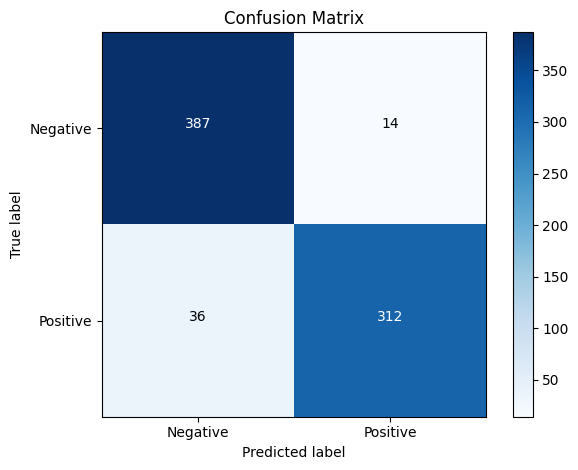

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and ground truth labels as numpy arrays
predictions = best_model.predict(x_test)
print(predictions)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
y_test1=np.argmax(y_test, axis=1)
print(y_test1.shape)
print(y_test.shape,predicted_labels.shape)
# Compute confusion matrix
cm = confusion_matrix(y_test1, predicted_labels)
labels = ['Negative', 'Positive']  # Define class labels

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Label the cells
thresh = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

48/48 [==============================] - 1s 20ms/step
[[1.0506306e-04 9.9989498e-01]
 [1.0000000e+00 5.2158602e-09]
 [1.0000000e+00 6.5503541e-10]
 ...
 [1.0000000e+00 9.8889049e-28]
 [6.6298968e-13 1.0000000e+00]
 [1.2292689e-10 1.0000000e+00]]


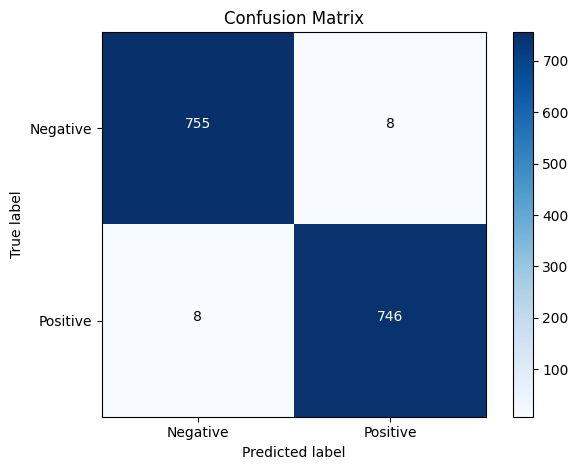

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and ground truth labels as numpy arrays
predictions = best_model.predict(x_val)
print(predictions)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
y_val1=np.argmax(y_val, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_val1, predicted_labels)
labels = ['Negative', 'Positive']  # Define class labels

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Label the cells
thresh = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

91/91 [==============================] - 3s 36ms/step
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


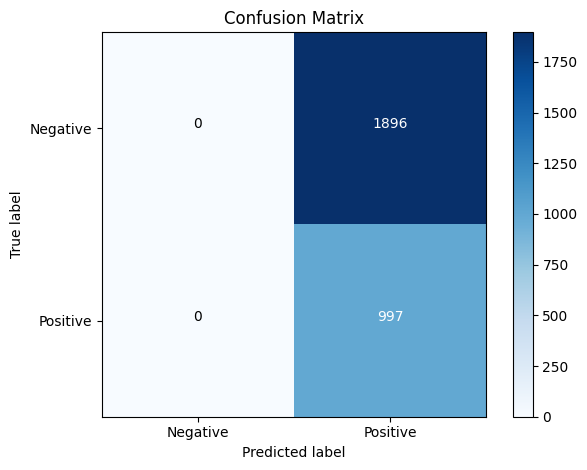

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and ground truth labels as numpy arrays
predictions = best_model.predict(x_train)
print(predictions)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
# y_train1=np.argmax(y_train, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_train, predicted_labels)
labels = ['Negative', 'Positive']  # Define class labels

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Label the cells
thresh = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [23]:
best_model.save('/content/drive/MyDrive/kerastunner4.h5')